# Problem 1: Convergence of Absolute Energies with Respect to Cutoff Energies
1. Using the Quantum ESPRESSO PWscf package, calculate the energy of Ge in the diamond structure as a function of plane-wave cutoff energy. A good range to try is 5- 80 Ry, doing calculations at increments of 5 Ry. When changing the cutoff, make sure to keep the other variables (lattice constant, k-points, etc) fixed and to record them. Record and plot your final results. Specify when you reach the level of convergence of around 5 meV/atom (convert this to Ry/atom). Note that the code calculates energy per primitive cell.

2. Do you see a trend in your calculated energies and calculation time with respect to the cutoff? Is this what you expect and why?

3. In Problem Set 1, we used a cubic unit cell. Here, we use the primitive cell. What are the advantages and disadvantages of both methods?


In [104]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

### Functions for automating Quantum Espresso calls
1. Below we define a few (crude) functions that help us create our input file for quantum espresso. 
2. Then we loop over different values for the cut off energy, calculate the total energy, and parse the qe output file to store values in a python array for plotting. 

In [16]:
def file_name(element_name):
    if (type(element_name) != str):
        return "Error: Please enter a valid element name string"
    return element_name + '.scf.in' 

In [17]:
def control(file_object, prefix, pseudo_dir = '.', outdir = '.'):
    
    # prefix line 
    file_object.write('&control\n')
    prefix_line = '    prefix = ' + "'" + prefix + "',"
    file_object.write(prefix_line + "\n")
    
    # pseudo dir line 
    pseudo_dir_line = '    pseudo_dir = ' + "'" + pseudo_dir + "',"
    file_object.write(pseudo_dir_line + "\n")
    
    # 
    outdir_line = '    outdir = ' + "'" + outdir + "',"
    file_object.write(outdir_line + "\n" + '/')
    file_object.write('\n')    

In [18]:
def system(file_object, ibrav, celldm_num, celldm, nat, ntyp, metal = 'no', ecutwfc = 20.0):
    # system
    file_object.write('&system\n')
    file_object.write('    ibrav = ' + str(ibrav) + ',\n')
    file_object.write('    celldm(' + str(celldm_num) + ') = ' + str(celldm) + ',\n')
    file_object.write('    nat = ' + str(nat) + ',\n')
    file_object.write('    ntyp = ' + str(ntyp) + ',\n')
    
    if (metal == 'yes'):
        file_object.write('    occupations = ' + " 'smearing', " + ',\n')
        file_object.write('    smearing = ' + "'mp'," + 'degauss = 0.06')
    
    file_object.write('    ecutwfc = ' + str(ecutwfc) + ',\n')
    
    file_object.write('/' + '\n')

In [19]:
def electrons(file_object):
    file_object.write('&electrons\n')
    file_object.write('/' + '\n')

In [20]:
def atomic_species(file_object, species, mass, pseudo_pot):
    """ extend functionality later """
    file_object.write('ATOMIC_SPECIES\n')
    file_object.write(' ' + species)
    file_object.write(' ' + str(mass))
    file_object.write(' ' + pseudo_pot + '\n')

In [43]:
def atomic_positions(file_object, dicti):
    """ need to link to ase later 
        accepts a dict: {species: location}
    """
    file_object.write('ATOMIC_POSITIONS\n')
    for species in dicti:
        file_object.write(" " + dicti[species] + "\n")

In [48]:
def k_points(file_object, k_points, offset = 0):
    file_object.write('K_POINTS automatic\n')
    k_points = str(k_points)
    if (offset == 0):
        file_object.write(' ' + k_points + ' ' + k_points + ' ' + k_points + ' 0 0 0' + "\n")
    else:
        file_object.write(' ' + k_points + ' ' + k_points + ' ' + k_points + ' 1 1 1' + "\n")

In [23]:
def file_write(element_name, struct):
    name = file_name(element_name[0] + element_name[1])
    f = open(name, 'w')
    
    control(f, element_name)
    system(f, 2, 1, 10.690181, 2, 1)
    electrons(f)
    atomic_species(f, element_name[0] + element_name[1], 72.64, 'ge_pbe_v1.4.uspp.F.UPF')
    
    #struct = {
    #            'Cu': '0.00 0.00 0.00'
    #}
    atomic_positions(f, struct)
    k_points(f, 8)
    
    f.close()

In [103]:
def parse_output(outfile):
    """ Parses the quantum espresso output file """
    
    with open(outfile, 'r') as outf:
        for line in outf:
            if (line.lower().startswith('     lattice parameter (alat)')):
                lattice_constant = float(line.split()[-2]) * 0.529177
            if (line.lower().startswith('!    total energy')):
                total_energy = float(line.split()[-2]) * 13.605698066
    
    result = {'energy': total_energy, 'lattice': lattice_constant}
    return result 

## Germanium

Germanium (Ge) has mass 72.64 au and a lattice constant of 10.69 Bohr. 
- Below we use an USPP pseudo-potential from materialscloud
- Use 8x8x8 K-points 
- Use a diamond structure which consists of an fcc structure with one atom at $(0,0,0)$ and the other at $(0.25, 0.25, 0.25)$. 


In [44]:
# diamond structure Germanium 

struct = {
    'atom1' : 'Ge 0.00 0.00 0.00', 
    'atom2' : 'Ge 0.25 0.25 0.25'
}

In [45]:
struct

{'atom1': 'Ge 0.00 0.00 0.00', 'atom2': 'Ge 0.25 0.25 0.25'}

In [46]:
def ge_file_write(element_name, struct, cut_off):
    name = file_name(element_name[0] + element_name[1])
    f = open(name, 'w')
    
    control(f, element_name, '/Users/vinhtran/Documents/GitHub/DFT/First_Principles_Energy_Methods/Problem_1',\
               '/Users/vinhtran/Documents/GitHub/DFT/First_Principles_Energy_Methods/Problem_1')
    system(f, 2, 1, 10.690181, 2, 1, 'no', cut_off)
    electrons(f)
    atomic_species(f, element_name[0] + element_name[1], 72.64, 'ge_pbe_v1.4.uspp.F.UPF')
    atomic_positions(f, struct)
    k_points(f, 8)

    f.close()
    return name 

In [33]:
cut_off_energies = np.arange(5.0, 85.0, 5.0)

In [82]:
total_energy = np.zeros(len(cut_off_energies))

for i in range(len(cut_off_energies)): 
    # Remove existing files 
    subprocess.run(["rm", "Ge.scf.in", "ge.scf.out"])
    # generate input file 
    name = ge_file_write('Germanium', struct, cut_off_energies[i])
    # call qe calculation in shell 
    subprocess.run('pw.x -in Ge.scf.in > ge.scf.out', shell=True)
    # parse output file and store values in result dict 
    result = parse_output('ge.scf.out')
    # getting the energy back 
    total_energy[i] = result['energy']

rm: ge.scf.out: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_

## Plotting the Results

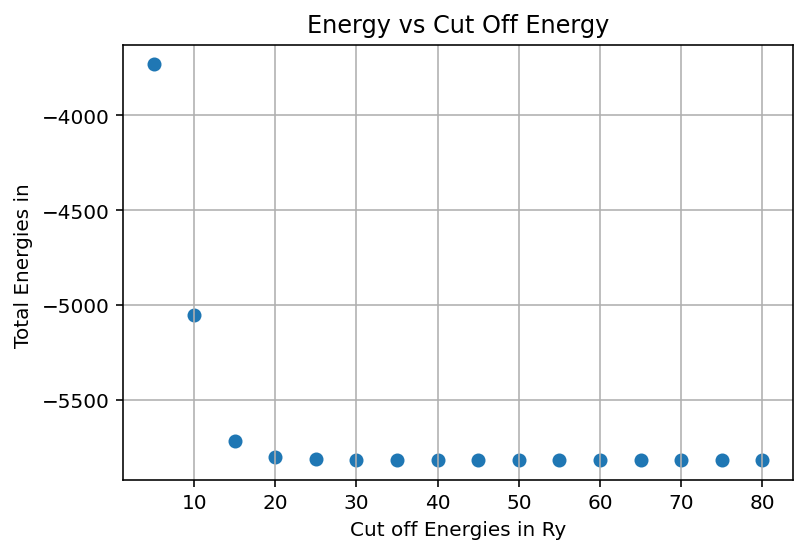

In [105]:
plt.scatter(cut_off_energies, total_energy)
plt.grid() 
plt.xlabel('Cut off Energies in Ry')
plt.ylabel('Total Energies in ')
plt.title('Energy vs Cut Off Energy')
#plt.show()
plt.savefig('energy_vs_cutoff.pdf')